Mounted at /content/drive
loaded 539747 rows and 24 columns

columns:
['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

filtered to 46497 rows from our hub airports
	raining model


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done training

results
accuracy: 0.7999
f1-score: 0.7331

classification report:
              precision    recall  f1-score   support

   Cancelled       0.15      0.01      0.02       152
     Delayed       0.43      0.06      0.11      1693
     On-Time       0.81      0.98      0.89      7455

    accuracy                           0.80      9300
   macro avg       0.47      0.35      0.34      9300
weighted avg       0.73      0.80      0.73      9300


confusion matrix:
[[   2   20  130]
 [   6  108 1579]
 [   5  121 7329]]


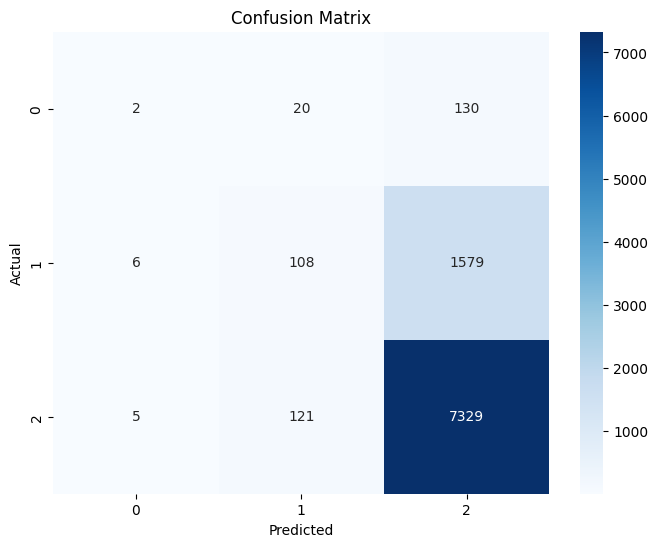

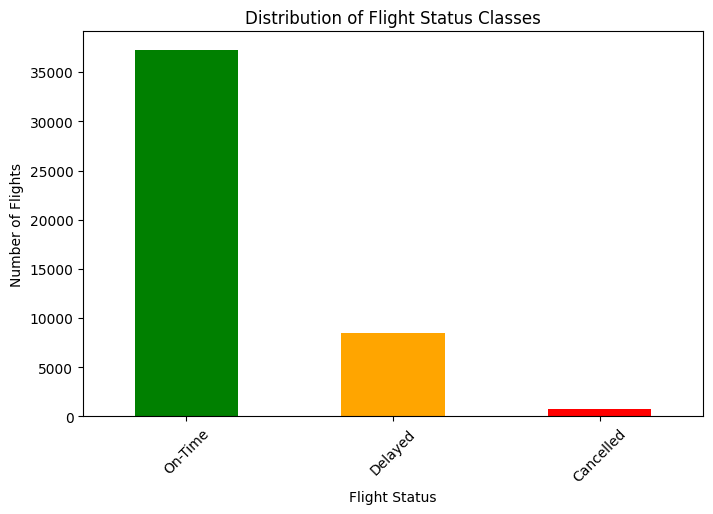

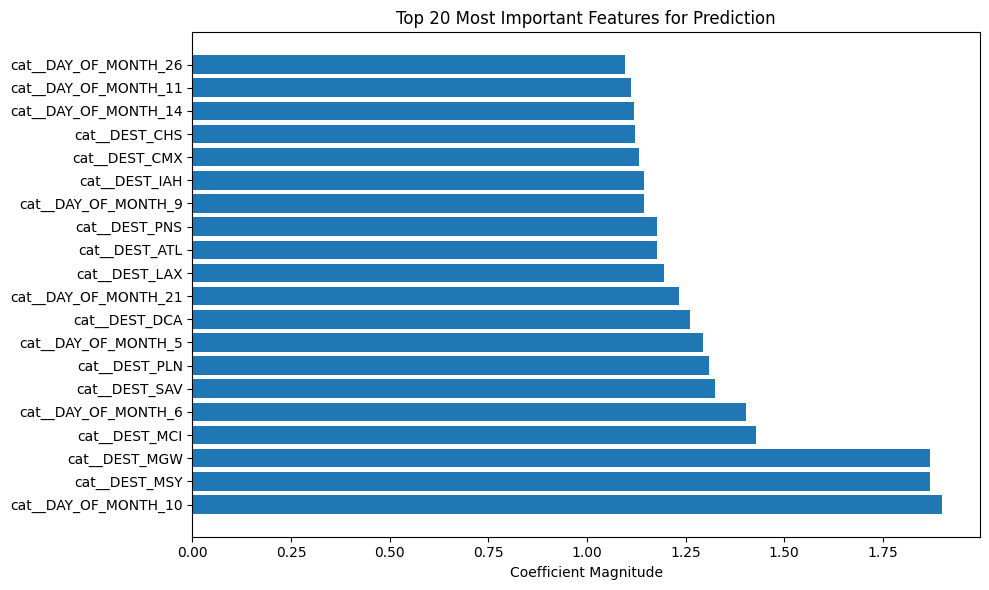

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# loading dataset from google drive which has flight info like delays, cancellations, airports, airlines, etc
file_path = '/content/drive/MyDrive/CS441/final_project/T_ONTIME_REPORTING.csv'

try:
    df = pd.read_csv(file_path, low_memory=False)
    print(f"loaded {df.shape[0]} rows and {df.shape[1]} columns")
    print("\ncolumns:")
    print(df.columns.tolist())
except FileNotFoundError:
    print(f"file not found at {file_path}")

# only looking at 5 hub airports: ORD, MDW, MKE, DTW, MSP
airport_codes = ['ORD', 'MDW', 'MKE', 'DTW', 'MSP']

# filter to only flights from these airports
df = df[df['ORIGIN'].isin(airport_codes)]
print(f"\nfiltered to {df.shape[0]} rows from our hub airports")

# dataset doesn't have a flight status column so I gotta make one
# this function labels each flight based on delay info
def get_flight_status(row):
    if row['CANCELLED'] == 1.0:
        return 'Cancelled'
    elif pd.isna(row['DEP_DELAY']):
        return 'Other'  # missing delay data, probably diverted
    elif row['DEP_DELAY'] > 15:
        return 'Delayed'  # over 15 min is considered delayed
    else:
        return 'On-Time'

# apply function to create the new column
df['Flight_Status'] = df.apply(get_flight_status, axis=1)

# drop 'other' rows since we only want on-time, delayed, or cancelled
df = df[df['Flight_Status'] != 'Other']

# picking features that would affect flight delays
# airline, airports, and timing info (month, day of week, etc)
features = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'QUARTER']
target = 'Flight_Status'  # what we're predicting

# X = inputs, y = output
X = df[features]
y = df[target]

# split 80-20 for training and validation
# stratify keeps same proportion of each class in both sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# all features are text so OneHotEncoder converts them to numbers
# handle_unknown='ignore' prevents errors if validation has new values
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), features)])

# pipeline chains preprocessing and model together
# first encodes categories, then runs logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=2000, random_state=42))
])

# train the model
print("\training model")
model.fit(X_train, y_train)
print("Done training")

# test on validation data
y_pred = model.predict(X_val)

# check results
print("\nresults")

# accuracy = percentage of correct predictions
accuracy = accuracy_score(y_val, y_pred)
print(f"accuracy: {accuracy:.4f}")

# f1-score is better for imbalanced data, combines precision and recall
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"f1-score: {f1:.4f}")

# detailed breakdown for each class
print("\nclassification report:")
print(classification_report(y_val, y_pred, zero_division=0))

# confusion matrix shows what model predicted vs actual, diagonal is correct and rest are errors
print("\nconfusion matrix:")
print(confusion_matrix(y_val, y_pred))

# making some graphs to visualize the results better
import matplotlib.pyplot as plt
import seaborn as sns

# plotting confusion matrix as a heatmap since it's easier to see than just numbers
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# bar chart to see how many flights are in each category
# helps visualize the class imbalance
plt.figure(figsize=(8, 5))
df['Flight_Status'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribution of Flight Status Classes')
plt.xlabel('Flight Status')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

# trying to see which features are most important for predictions
# getting coefficients from the logistic regression model
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coefficients = model.named_steps['classifier'].coef_

# plotting the top 20 features (using the first class coefficients)
plt.figure(figsize=(10, 6))
# using absolute values to see importance regardless of positive or negative
importance = abs(coefficients[0])
top_indices = importance.argsort()[-20:][::-1]  # getting top 20
plt.barh(range(20), importance[top_indices])
plt.yticks(range(20), [feature_names[i] for i in top_indices])
plt.xlabel('Coefficient Magnitude')
plt.title('Top 20 Most Important Features for Prediction')
plt.tight_layout()
plt.show()